https://torchgeo.readthedocs.io/en/stable/tutorials/trainers.html

https://torchgeo.readthedocs.io/en/v0.2.1/tutorials/trainers.html

In [2]:
%matplotlib inline
import os
import csv
import tempfile

import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchgeo.datamodules import CycloneDataModule
from torchgeo.trainers import RegressionTask

In [3]:
# we set a flag to check to see whether the notebook is currently being run by PyTest, if this is the case then we'll
# skip the expensive training.
in_tests = "PYTEST_CURRENT_TEST" in os.environ

In [6]:
# Set this to your API key (available for free at https://mlhub.earth/)
MLHUB_API_KEY = os.environ["MLHUB_API_KEY"]

In [7]:
data_dir = os.path.join(tempfile.gettempdir(), "cyclone_data")

datamodule = CycloneDataModule(
    root_dir=data_dir, seed=1337, batch_size=64, num_workers=6, api_key=MLHUB_API_KEY
)

In [8]:
task = RegressionTask(
    model="resnet18",
    pretrained=True,
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
)

In [9]:
experiment_dir = os.path.join(tempfile.gettempdir(), "cyclone_results")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath=experiment_dir, save_top_k=1, save_last=True
)

early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)

csv_logger = CSVLogger(save_dir=experiment_dir, name="tutorial_logs")

In [10]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[csv_logger],
    default_root_dir=experiment_dir,
    min_epochs=1,
    max_epochs=10,
    fast_dev_run=in_tests,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model=task, datamodule=datamodule)

  0%|          | 0/1446.5 [00:00<?, ?M/s]

  0%|          | 0/918.3 [00:00<?, ?M/s]

  0%|          | 0/7.5 [00:00<?, ?M/s]

  0%|          | 0/4.6 [00:00<?, ?M/s]


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.2 M
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/anne/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/home/anne/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
if not in_tests:
    train_steps = []
    train_rmse = []

    val_steps = []
    val_rmse = []
    with open(
        os.path.join(experiment_dir, "tutorial_logs", "version_0", "metrics.csv"), "r"
    ) as f:
        csv_reader = csv.DictReader(f, delimiter=",")
        for i, row in enumerate(csv_reader):
            try:
                train_rmse.append(float(row["train_RMSE"]))
                train_steps.append(i)
            except ValueError:  # Ignore rows where train RMSE is empty
                pass

            try:
                val_rmse.append(float(row["val_RMSE"]))
                val_steps.append(i)
            except ValueError:  # Ignore rows where val RMSE is empty
                pass

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/cyclone_results/tutorial_logs/version_0/metrics.csv'

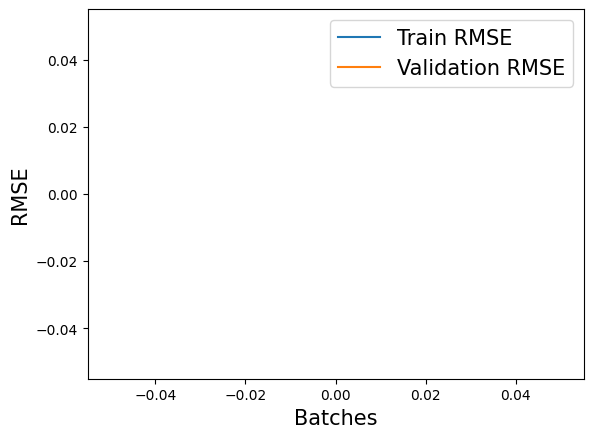

In [13]:
if not in_tests:
    plt.figure()
    plt.plot(train_steps, train_rmse, label="Train RMSE")
    plt.plot(val_steps, val_rmse, label="Validation RMSE")
    plt.legend(fontsize=15)
    plt.xlabel("Batches", fontsize=15)
    plt.ylabel("RMSE", fontsize=15)
    plt.show()
    plt.close()

In [14]:
trainer.test(model=task, datamodule=datamodule)

Files already downloaded and verified


Testing: 0it [00:00, ?it/s]

/home/anne/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
